# Simulator Testing 0

The following code defines an ellipse corresponding to the path around the globe an orbit takes

In [41]:
%matplotlib ipympl

import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mplp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider
import scipy
import datetime
from nrlmsise00 import msise_model



radius_polar = 6356752
radius_equatorial = 6378137
earth_eccentricity_squared = 6.694379e-3
M_e = 5.972e24
G = 6.673e-11
rho_0 = 1.225
H = 8400.0
A = np.pi * (3.3 / 2)**2  # m^2, satellite windward area
stellar_day  = 86164.1
earth_rotation_s = 1/360 * stellar_day

In [2]:
def satellite_forces_simple(altitude, velocity, C_d):
    # Extract coordinates

    # Atmospheric density calculation
    rho = rho_0 * np.exp(-altitude / H)

    velocity = np.array(velocity)
    # Drag force calculation
    Fd = 0.5 * rho * velocity**2 * C_d * A

    return Fd

In [3]:
def satellite_forces_complex(time, position, lat, lon, velocity, altitude, C_d = 2.2):

    # Convert position vector to Earth center coordinates
    
    # Obtain atmospheric density using the NRLMSISE-00 model
    output = msise_model(time, altitude, lat, lon, 150, 150, 4, lst=16)
    #first 150 is the 81-day sliding average of solar aactivity, representing the solar radiation index
    #seconde 150 is the previous day sliding average of solar activity, representing the solar radiation index
    # 4 is the index of geomagnetic activity reflects the degree of disturbance of the Earth's magnetic field
    # lst=16 is the local solar time
    rho = output[0][5]  # Total mass density in kg/m^3

    # Calculate drag force components
    velocity = np.array(velocity)

    Fd = 0.5 * rho * velocity**2 * C_d * A

    return Fd  # Return both magnitude and direction tuple

In [4]:
def Cart2Spher(positions):
    sphercoords = np.zeros(positions.shape)
    xy2 = positions[:,0]**2 + positions[:,1]**2
    sphercoords[:,0] = np.sqrt(xy2 + positions[:,2]**2)
    sphercoords[:,1] = np.arctan2(np.sqrt(xy2), positions[:,2])
    sphercoords[:,2] = np.arctan2(positions[:,1],positions[:,0])
    return sphercoords

def Spher2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.sin(positions[:,1]) * np.cos(positions[:,2])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1]) * np.sin(positions[:,2])
    cartcoords[:,2] = positions[:,0] * np.cos(positions[:,1])
    return cartcoords

def Geodetic2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    N_phi = radius_equatorial / (np.sqrt(1 - earth_eccentricity_squared*np.sin(positions[:,0])**2))
    cartcoords[:,0] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.cos(positions[:,1])
    cartcoords[:,1] = (N_phi + positions[:,2]) * np.cos(positions[:,0]) * np.sin(positions[:,1])
    cartcoords[:,2] = ((1-earth_eccentricity_squared)*N_phi + positions[:,2]) * np.sin(positions[:,0])
    return cartcoords

def Cart2Geodetic(positions):
    geodeticcoords = np.zeros(positions.shape)
    geodeticcoords[:,1] = np.arctan2(positions[:,1], positions[:,0])
    k_0 = 1/(1 - earth_eccentricity_squared)
    k = k_0
    p = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
    for i in range(3):
        ci = ((p**2 + (1-earth_eccentricity_squared) * positions[:,2]**2 * k**2)**(3/2))/ (radius_equatorial * earth_eccentricity_squared)
        k = 1 + (p**2 + (1-earth_eccentricity_squared)*positions[:,2]**2*k**3)/(ci - p**2)
    
    geodeticcoords[:,2] = 1/earth_eccentricity_squared * (1/k - 1/k_0) * np.sqrt(p**2 + positions[:,2]**2 * k **2)
    geodeticcoords[:,0] = np.arctan2((k * positions[:,2]), p)
    return geodeticcoords

def Polar2Cart(positions):
    cartcoords = np.zeros(positions.shape)
    cartcoords[:,0] = positions[:,0] * np.cos(positions[:,1])
    cartcoords[:,1] = positions[:,0] * np.sin(positions[:,1])
    return cartcoords

def Cart2Polar(positions):
    polarcoords = np.zeros(positions.shape)
    polarcoords[:,0] = np.sqrt(positions[:,0]**2 + positions[:,1]**2)
    polarcoords[:,1] = np.arctan2(positions[:,1],positions[:,0])
    return polarcoords

In [5]:
test_points = np.array([[1,1],[1,2]])
Cart2Polar(Polar2Cart(test_points))

array([[1., 1.],
       [1., 2.]])

In [6]:
class Ellipse:
    def __init__(self, centre, height, width, angle=0):
        self.x, self.y = centre
        self.w = width
        self.h = height
        self.theta = angle
    
    def r(self):
        """
        Defines the rotation matrix used to transform coordinates to 0-centred model
        """
        a = np.cos(self.theta)
        b = np.sin(self.theta)
        return np.array([[a,-b],[b,a]])
    
    def point_at_angle(self, angle):
        """
        Given an interior angle from an ellipse's centre, finds a point on the ellipse.
        """
        #Compute location of original point
        x_or = 0.5 * self.w * np.cos(angle)
        y_or = 0.5 * self.h * np.sin(angle)

        #rotate the point to the centred version of the ellipse
        rot_point = np.dot(self.r(), [x_or, y_or]) + [self.x, self.y]
        return rot_point
    
    def multi_points(self, locations):
        """
        Given an array of interior angles, this returns an array of positions on the ellipse.
        """
        points_array = []
        for loc in locations:
            points_array.append(self.point_at_angle(loc))
        return np.array(points_array)
    
    def closest_point(self, x, tol=1e-6, max_iter = 100):
        """
        Given a point outside the ellipse, and finds the point on the ellipse closest to this.
        It also returns the (smallest) distance between the point and the ellipse.
        """
        #First need to project the point to the space where ellipse centred at origin
        #Also, need to initialize the constants
        x = np.asarray(x)
        x2 = np.dot(self.r().T, x - [self.x, self.y])
        d0 = np.arctan2(x2[1], x2[0])
        a = 0.5 * self.w
        b = 0.5 * self.h
        #Check if points are in the interior of the ellipse
        if (x2[0] / a)**2 + (x2[1] / b)**2 <1:
            print("Satellite has Crashed!")
            return np.array(0), None
        
        iterations = 0
        ds = [d0]
        xs = []
        errors = [tol]

        while errors[-1] >= tol and iterations < max_iter:
            x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
            xs.append(x1)
            dx1dt = np.array([-a *np.sin(ds[-1]), b * np.cos(ds[-1])])
            dx1dt2 = np.array([-a * np.cos(ds[-1]), -b * np.sin(ds[-1])])
            dD2dt = 2*np.dot(dx1dt,(x1 - x2))
            dD2dt2 = 2*np.dot(dx1dt2,(x1-x2)) + 2*np.dot(dx1dt,dx1dt)
            ds.append(ds[-1] - dD2dt / dD2dt2)
            errors.append(np.abs(dD2dt/dD2dt2))
            iterations +=1
        
        x1 = np.array([a * np.cos(ds[-1]), b * np.sin(ds[-1])])
        dist = np.linalg.norm(x1 - x2)
        return dist, xs[-1]




To Be Fixed: currently only keeps track of position for (0,0) centred ellipse coords! Needs to be fixed!

In [7]:
#Here are some global variables
polar_ellipse = Ellipse((0,0), 2*radius_polar, 2*radius_equatorial)
simple_polar_ellipse = Ellipse((0,0), 2*(radius_polar/1000), 2*(radius_equatorial/1000))

In [8]:
class D2_Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc, tangential_velocity = False):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        self.mass = mass
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        if tangential_velocity == True:
            angle = np.arctan2(self.position[1],self.position[0])
            self.velocity = [np.cos(angle) * init_veloc, np.sin(angle) * init_veloc]
        else:
            self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]

    def calcAltitude(self, ell: Ellipse):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """
        altitude, ground_pos = ell.closest_point(self.position)
        return altitude, ground_pos
    
    def calcGravAcc(self, ell: Ellipse):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position) - np.array([ell.x, ell.y]))**2
        theta = np.arctan2(self.position[1], self.position[0])
        return np.array([grav_acc * np.cos(theta),grav_acc * np.sin(theta)])

    def calcDrag(self, altitude):
        """
        Ideally takes a reference from the physical parameters team to estimate drag
        """
        drag = satellite_forces_simple(altitude, self.velocity, self.dragcoeff)
        return drag
        
        

    def FEtimeStep(self, ell: Ellipse, dt):
        """
        Takes a timestep using Forward Euler
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return 
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = drag_a + grav_a
        new_veloc = self.velocity + dt * tot_a
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        new_position = self.position + dt * self.velocity
        self.position = new_position
        self.poshist.append(new_position)
    
    def Gen_TimeStep(self, ell: Ellipse, dt, solver='RK45'):
        self.altitude, groundpos = self.calcAltitude(ell)
        if self.altitude <=0:
            return
        drag_a = self.calcDrag(self.altitude) / self.mass
        grav_a = self.calcGravAcc(ell)
        tot_a = drag_a + grav_a
        veloc_func = lambda t, v: tot_a
        veloc_sol = scipy.integrate.solve_ivp(veloc_func, [0,dt], self.velocity, method=solver, t_eval = [dt])
        new_veloc = [veloc_sol.y[0][0].tolist(),veloc_sol.y[1][0].tolist()]
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        pos_func = lambda t,x: self.velocity
        pos_sol = scipy.integrate.solve_ivp(pos_func, [0,dt], self.position, method=solver, t_eval=[dt])
        new_pos = [pos_sol.y[0][0].tolist(),pos_sol.y[1][0].tolist()]
        self.position = new_pos
        self.poshist.append(new_pos)
    
    def forecast(self, ell: Ellipse, dt=0.001, maxIter = 100000, height_tol = 10000, simple_solver = False, solver = 'RK45'):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude(ell)
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        if simple_solver == True:
            while self.altitude > height_tol and iter < maxIter:
                self.FEtimeStep(ell, dt)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter +=1
            return self.poshist, self.velochist, self.althist
        
        else:
            while self.altitude > height_tol and iter < maxIter:
                self.Gen_TimeStep(ell, dt, solver=solver)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter += 1
            return self.poshist, self.velochist, self.althist


In [9]:
sat1 = D2_Satellite(3000, 2.2, [7378000, 0], [-7000,0])
ell1 = Ellipse((0,0), radius_equatorial*2, radius_equatorial*2)

In [10]:
#print(ell1.closest_point([7378, 0]))
sat1 = D2_Satellite(3000, 2.2, [0, radius_equatorial+1000000], [7000,0])
ell1 = Ellipse((0,0), radius_equatorial*2, radius_equatorial*2)
dt = 0.1
poshist, velochist, althist = sat1.forecast(ell1, dt = dt, height_tol = 0)

Satellite has Crashed!


In [11]:
def D2_orbitplotter(poshist, althist, ell1,dt):
    fig, axs = plt.subplots(1,2)
    axs.flatten()[0].plot(althist[0::int(1/dt)], label = "Altitude")
    axs.flatten()[0].set_xlabel("Time (s)")
    axs.flatten()[0].set_ylabel("Altitude (m)")
    axs.flatten()[0].set_title("Altitude of Satellite")
    axs.flatten()[0].legend()
    ellipse = mplp.Ellipse((ell1.x,ell1.y),ell1.w, ell1.h, angle = ell1.theta, fill=False, color = 'r')
    axs.flatten()[1].add_patch(ellipse)
    axs.flatten()[1].plot(poshist[:,0], poshist[:,1], label = "Position")
    axs.flatten()[1].set_aspect('equal')
    axs.flatten()[1].set_title("Path of Satellite (2D Projection)")
    #axs.flatten()[1].legend(loc='upper left')

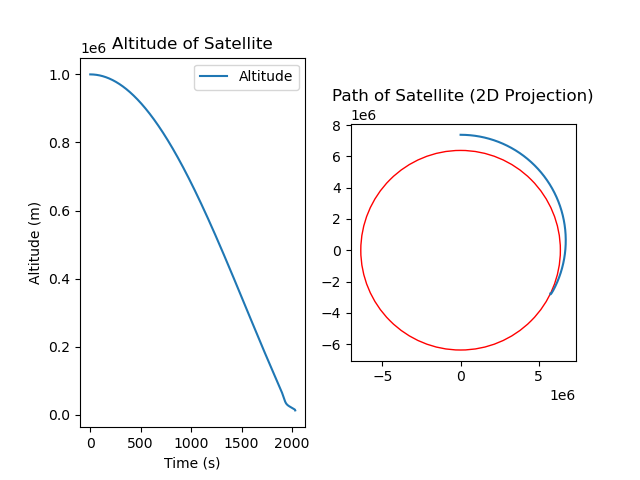

In [12]:
poshist = np.array(poshist)
D2_orbitplotter(poshist, althist, ell1, dt)

In [13]:
radar_angs = np.arange(0,2*np.pi,np.pi/2)
positions = ell1.multi_points(radar_angs)
noisy_position = np.zeros(poshist.shape)
for position in poshist:
    noisy_position = position + np.random.normal(0,0.03*np.abs(position))
np.savetxt("data_test.csv", noisy_position, delimiter=",")

In [14]:
class D3_Satellite:
    def __init__(self, mass, dragcoeff, init_position, init_veloc, time = datetime.datetime(2009, 6, 21, 8, 3, 20)):
        """
        Begin by defining relevant attributes of a satellite, initial poisition,
        and set up arrays to track movement of satellite.
        """
        
        self.mass = mass
        self.time = time
        self.altitude = None
        self.althist = None
        self.dragcoeff = dragcoeff
        self.position = init_position
        self.velocity = init_veloc
        self.poshist = [init_position]
        self.velochist = [init_veloc]
    
    def calcAltitude(self, kilometers = True):
        """
        Given a satellite and an ellipse, this performs the same calculation as the ellipse
        But more from a "Sattelite" POV
        """

        spher_coords = Cart2Spher(np.array([self.position]))[0][:2]
        transformed_coords = Polar2Cart(np.array([[spher_coords[0],-spher_coords[1]+np.pi/2]]))[0]
        
        if kilometers == True:
            altitude, ground_pos = simple_polar_ellipse.closest_point(transformed_coords)
        else:
            altitude, groundpos = polar_ellipse.closest_point(transformed_coords)
        return altitude, ground_pos
    
    def calcGravAcc(self, kilometers = True):
        """
        Given a satellite's position, and accounting for non-zero-centred ellipses, computes
        The gravitational accelleration experienced by the satellite at that position
        """
        grav_acc = -G*M_e / np.linalg.norm(np.array(self.position))**2
        if kilometers == True:
            grav_acc = grav_acc/1e9
        normpos = self.position / np.linalg.norm(self.position)
        grav_acc_direct = grav_acc * np.array(normpos)
        return grav_acc_direct
    
    def calcDragForce(self, drag_type):
        
        if self.altitude is None:
            self.altitude, _ = self.calcAltitude()
            self.althist = [self.altitude]
        
        if drag_type.lower().strip() == 'complex':
            [_, lat, lon] = Cart2Spher(np.array([self.position]))[0]
            drag_force = satellite_forces_complex(self.time, self.position, lat, lon, self.velocity, self.altitude, C_d = self.dragcoeff)
        else:
            drag_force = satellite_forces_simple(self.altitude, self.velocity, self.dragcoeff)
        return drag_force
    
    def Gen_TimeStep(self, dt, drag_type, solver='RK45', kilometers = True):
        self.altitude, groundpos = self.calcAltitude()
        if self.altitude <=0:
            return
        drag_a = self.calcDragForce(drag_type) / self.mass
        grav_a = self.calcGravAcc(kilometers = kilometers)
        tot_a = drag_a + grav_a
        veloc_func = lambda t, v: tot_a
        veloc_sol = scipy.integrate.solve_ivp(veloc_func, [0,dt], self.velocity, method=solver, t_eval = [dt])
        new_veloc = [veloc_sol.y[0][0].tolist(),veloc_sol.y[1][0].tolist(),veloc_sol.y[2][0].tolist()]
        self.velocity = new_veloc
        self.velochist.append(new_veloc)
        pos_func = lambda t,x: self.velocity
        pos_sol = scipy.integrate.solve_ivp(pos_func, [0,dt], self.position, method=solver, t_eval=[dt])
        new_pos = [pos_sol.y[0][0].tolist(),pos_sol.y[1][0].tolist(),pos_sol.y[2][0].tolist()]
        self.position = new_pos
        self.poshist.append(new_pos)
        self.time += datetime.timedelta(0,dt)
    
    def forecast(self, dt=0.001, maxIter = 100000, height_tol = 0, simple_solver = False, solver = 'RK45', drag_type = 'complex', kilometers = True):
        """
        Runs the forward euler timestep until our altitude reaches 0. Can adjust dt as seen fit
        To be fixed: breaks when altitude drops below 10km or so.
        """
        self.altitude, groundpos = self.calcAltitude()
        iter = 0

        if self.althist is None:
            self.althist = [self.altitude]
        
        if simple_solver == False:
            while self.altitude > height_tol and iter < maxIter:
                self.Gen_TimeStep(dt, drag_type, solver=solver, kilometers = kilometers)
                self.althist.append(self.altitude)
                #print(self.altitude)
                iter += 1
            
            if iter == maxIter and self.altitude != 0.0:
                print(f"Satellite failed to crash after {1/dt * maxIter} seconds.")
            return self.poshist, self.velochist, self.althist
    


In [15]:
init_position = [0, 0, radius_equatorial/1000 + 1000]
a = 7.65**2
sat = D3_Satellite(3000, 2.2, init_position, [0,7,0])
dt = 0.1
poshist, _, althist = sat.forecast(dt = dt, maxIter = 100000)

Satellite has Crashed!


In [16]:
def ellipsoid_surface(a, b, c, num_points=100):
    """
    Quick function that creates 3D map of the earth's surface (oblate ellispoid)
    a and b are equatorial radius, c is the polar radius
    """
    u = np.linspace(0, 2*np.pi, num_points)
    v = np.linspace(0, 2*np.pi, num_points)
    x = a * np.outer(np.cos(u), np.sin(v))
    y = a * np.outer(np.sin(u), np.sin(v))
    z = c * np.outer(np.ones_like(u), np.cos(v))
    return [x, y, z]

earth_ellipsoid = ellipsoid_surface(radius_equatorial//1000, radius_equatorial//1000,radius_polar//1000, num_points = 1000)

In [17]:
def Orbit_Plotter_3D(althist, poshist):
    poshist = np.array(poshist)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(earth_ellipsoid[0],earth_ellipsoid[1],earth_ellipsoid[2])
    ax.plot(poshist[:,0],poshist[:,1],poshist[:,2])

    ax_elevation = plt.axes([0.1,0.02,0.8,0.02])
    ax_azimuth = plt.axes([0.1,0.05,0.8,0.02])
    slider_elevation = Slider(ax_elevation, 'Elevation', -180, 180, valinit=30)
    slider_azimuth = Slider(ax_azimuth, 'Azimuth', -180, 180, valinit=-60)

    def update_view(val):
        ax.view_init(elev=slider_elevation.val, azim=slider_azimuth.val)

    # Register the update function with the sliders
    slider_elevation.on_changed(update_view)
    slider_azimuth.on_changed(update_view)
    plt.show()
    return fig

In [18]:
class D2_radar_array:
    def __init__(self, cart_pos):
        self.positions = np.array(cart_pos)
    
    def general_identify(self, id_pos):
        id_pos = np.array(id_pos)
        found_pos = []
        for i, id_pos_i in enumerate(id_pos):
            found_pos_i = np.zeros(np.array(self.positions).shape)
            for j, pos in enumerate(self.positions):
                found_pos_i[j,:] = id_pos_i - pos
            found_pos.append(found_pos_i)
        return found_pos
    
    def satellite_identify(self, sat: D2_Satellite, noise_level = 0.05):
        poshist = self.general_identify(poshist)
        noisy_pos = np.zeros(np.array(poshist).shape)
        for i, pos in enumerate(poshist):
            for j in range(len(pos)):
                noisy_pos[i][j] = pos[j] + np.random.normal(0,np.abs(noise_level*np.linalg.norm(pos)))
        return np.array(self.general_identify(poshist))


In [19]:
class D3_radar_array:
    def __init__(self, cart_pos):
        self.positions = cart_pos
    
    def general_identify(self, id_pos):
        id_pos = np.array(id_pos)
        found_pos = []
        for i, id_pos_i in enumerate(id_pos):
            found_pos_i = np.zeros(np.array(self.positions).shape)
            for j, pos in enumerate(self.positions):
                found_pos_i[j,:] = id_pos_i - pos
            found_pos.append(found_pos_i)
        return np.array(found_pos)
    
    def satellite_identify(self, sat: D3_Satellite, noise_level = 0.05):
        sat_poshist = self.general_identify(poshist)
        noisy_pos = np.zeros(np.array(sat_poshist).shape)
        for i, pos in enumerate(sat_poshist):
            for j in range(len(pos)):
                noisy_pos[i][j] = pos[j] + np.random.normal(0,np.abs(noise_level*np.linalg.norm(pos)))
        return noisy_pos

In [20]:
def Equatorial_Array(num_arrays):
    
    basic_3D_array = np.zeros((num_arrays,3))
    long_interval = 2 * np.pi / num_arrays
    longs = np.arange(0, 2*np.pi, long_interval)
    for i in range(num_arrays):
        basic_3D_array[i,:] = Spher2Cart(np.array([[radius_equatorial/1000, np.pi/2, longs[i]]]))
    return D3_radar_array(basic_3D_array)


In [51]:
def Ellipse_Array_2D(ell: Ellipse, num_arrays):

    basic_2D_array = np.zeros((num_arrays, 2))
    ang_interval = 2 * np.pi / num_arrays
    angs = np.arange(0, 2*np.pi, ang_interval)
    for i in range(num_arrays):
        basic_2D_array[i,:] = ell.point_at_angle(angs[i])
    return D2_radar_array(basic_2D_array)

In [53]:
num_arrays = 4
D2_radar_stations = Ellipse_Array_2D(ell1, num_arrays)

In [21]:
num_arrays = 6
equatorial_radar_stations = Equatorial_Array(num_arrays)

In [54]:
noise_level = 0.02
#equatorial_radar_stations.satellite_identify(sat, noise_level) 

In [ ]:
def Simulator_2D(ellipse_parameters, satellite_parameters, radar_parameters, dt = 0.1, maxIter = 1000000, solver = 'RK45', simple_solver = False, simple_radar = True):
    """
    Collecting all of the information to create the ultimate 2D simulator

    ellipse_parameters: contains the centre, width, height and angle of slant for an ellipse

    satellite_parameters: must contain the mass, drag coefficient, initial posiiton, initial velocity, and initial time of the satellite.

    radar_parameters:
        - if passing the simple_radar = True flag, must contain an integer corresponding to the number of equidistributed radars on the equator
        - if passing the simple_radar = False flag, must contain an array of xyz coordinates corresponding to radar positions on the earth
    
    dt: contains the value for the timestepping algorithm dt = 0.1 is pretty ok at performance
    maxIter: how many iterations the forward step runs. default is 1,000,000. Consider reducing this if you're going to model stable orbits!
    solver: what solver to use for forward stepping the satellite's position
    simple_solver: Whether or not to use forward Euler as a method for forward stepping. Recommended to be set to False
    simple_radar: A flag whether or not to use equally spaced radar arrays or not (see radar_parameters for required inputs for each flag value)
    """


In [46]:
def Simulator(satellite_parameters, radar_parameters, dt = 0.1, maxIter = 1000000, solver = 'RK45', kilometers = True, simple_solver = False, drag_type = 'complex', simple_radar = True):
    """
    Collecting all of the information to create the ultimate 3D simulator

    satellite_parameters: must contain the mass, drag coefficient, initial posiiton, initial velocity, and initial time of the satellite.

    radar_parameters:
        - if passing the simple_radar = True flag, must contain an integer corresponding to the number of equidistributed radars on the equator
        - if passing the simple_radar = False flag, must contain an array of xyz coordinates corresponding to radar positions on the earth
    
    dt: contains the value for the timestepping algorithm dt = 0.1 is pretty ok at performance
    maxIter: how many iterations the forward step runs. default is 1,000,000. Consider reducing this if you're going to model stable orbits!
    solver: what solver to use for forward stepping the satellite's position
    kilometers: A flag to use km or m for values (recommended to use km)
    simple_solver: Whether or not to use forward Euler as a method for forward stepping. Recommended to be set to False
    drag_type: What kind of atmospheric model to use. "complex" uses nmrlsise00.
    simple_radar: A flag whether or not to use Equatorial radar arrays or not (see radar_parameters for required inputs for each flag value)
    """
    [mass, dragcoeff, init_position, init_veloc, time] = satellite_parameters.values()
    satellite = D3_Satellite(mass, dragcoeff, init_position, init_veloc, time)
    poshist, velochist, althist = satellite.forecast(dt = dt, maxIter = maxIter, simple_solver = simple_solver, solver = solver, drag_type = drag_type, kilometers = kilometers)
    pos_collision = poshist[-1]
    total_time = time - satellite.time

    #LatLon Collision accounts for Earth Orbiting around its own Axis
    latlon_collision = Cart2Spher(np.array([pos_collision]))[1:]

    if simple_radar:
        num_radars = radar_parameters
        radars = Equatorial_Array(num_radars)
    else:
        radar_positions = radar_parameters
        radars = D3_radar_array(radar_positions)
    noisy_readings = radars.satellite_identify(satellite)[::int(np.ceil(10*1/dt))]
    
    np.savetxt("Radar_Readings.csv", np.reshape(noisy_readings,(-1,3)), delimiter=",")
    np.savetxt("Radar_Positions.csv", radars.positions, delimiter=',')
    important_dict = {
        "Satellite Initial Position": init_position,
        "Satellite Initial Velocity": init_veloc,
        "Satellite Mass": mass,
        "Satellite Drag Coefficient": dragcoeff,
        "Initial Time": time.timestamp(),
        "XYZ Collision": pos_collision,
        "LatLong Collision": latlon_collision.tolist(),
        "Time of Collision (s since epoch)": satellite.time.timestamp(),
    }
    with open("Satellite_Information.json", "w") as outfile:
        json.dump(important_dict, outfile)
    
    return (poshist, althist)

In [47]:
satellite_parameters = {
    'mass': 3000,
    'drag coefficient': 2.2,
    'initial position': [0, 0, radius_equatorial/1000 + 1000],
    'initial velocity': [np.sqrt(6), np.sqrt(42), 0],
    'time': datetime.datetime(2024, 5, 8, 19, 33, 20)
}
radar_parameters = 5

poshist, althist = Simulator(satellite_parameters, radar_parameters)

Satellite has Crashed!


C:\Users\auror\AppData\Local\Temp\ipykernel_19096\477633004.py:41: UserWarning: frames=<tuple_iterator object at 0x000002495DB10BB0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, N, fargs = (poshist, line), interval = 100, blit=False)
MovieWriter imagemagick unavailable; using Pillow instead.


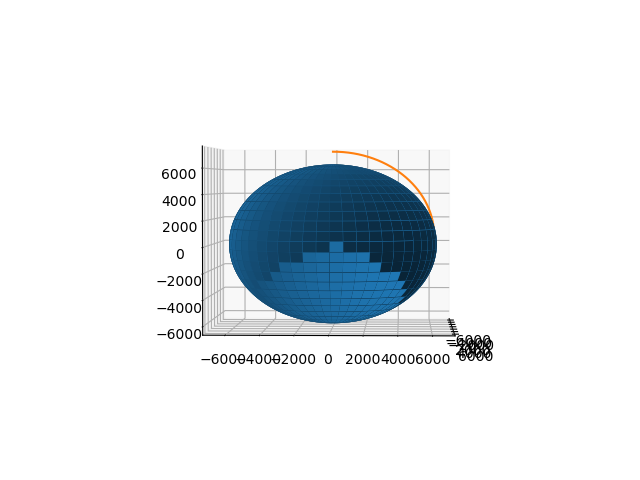

In [43]:
from matplotlib import animation

poshist = np.array(poshist)
init_elev = Cart2Spher(np.array([poshist[0]]))[0][1]
final_azmth = Cart2Spher(np.array([poshist[-1]]))[0][2]

fig = plt.figure()
plt.axis('off')
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot_surface(earth_ellipsoid[0],earth_ellipsoid[1],earth_ellipsoid[2])
line, = ax1.plot(poshist[:,0],poshist[:,1],poshist[:,2])

ax1.view_init(elev = init_elev + np.pi/2, azim = final_azmth + np.pi/4)

# ax_elevation = plt.axes([0.15,0.02,0.4,0.02])
# ax_azimuth = plt.axes([0.15,0.05,0.4,0.02])
# slider_elevation = Slider(ax_elevation, 'Elevation', -180, 180, valinit=0)
# slider_azimuth = Slider(ax_azimuth, 'Azimuth', -180, 180, valinit=-60)

# def update_view(val):
#     ax.view_init(elev=slider_elevation.val, azim=slider_azimuth.val)

def update(num, poshist, line):
    line.set_data(np.array([poshist[:num,0], poshist[:num,1]]))
    line.set_3d_properties(np.array(poshist[:num,2]))

# Register the update function with the sliders
# slider_elevation.on_changed(update_view)
# slider_azimuth.on_changed(update_view)

# times = np.arange(0,len(althist)) * (dt)
# ax2 = fig.add_subplot(122)
# ax2.plot(times, althist)
# ax2.set_xlabel("Time (s)")
# ax2.set_ylabel("Altitude (km)")
# ax2.set_title("Altitude of Satellite")

N = np.arange(0,len(poshist),100).tolist()
N.append(len(poshist)-1)
N = iter(tuple(N))
ani = animation.FuncAnimation(fig, update, N, fargs = (poshist, line), interval = 100, blit=False)
ani.save('SatelliteCrash.gif', writer='imagemagick')
plt.subplots_adjust(wspace = 0.9)

In [37]:
ani.pause()

In [38]:
ani.resume()